<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/MA_GAN_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0rc2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd

     |████████████████████████████████| 86.3MB 1.4MB/s 
     |████████████████████████████████| 3.8MB 28.6MB/s 
     |████████████████████████████████| 501kB 43.1MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0rc3
    Uninstalling tensorflow-1.15.0rc3:
      Successfully uninstalled tensorflow-1.15.0rc3


###Systemparameter
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [0]:
k = 9      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 6     # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results
D_nb_weights = 32
G_nb_weights = 32


batch_size = 100

x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )


## Generator Model

In [0]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

#numpy version of kl divergence
def kl_divergence_np(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w=1e-5
    p = p + w
    q = q + w
    return np.sum(p * np.log(p / q))

#tensorflow version of kl divergence
def kl_divergence_tf(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w = 1e-5
    p = p + w
    q = q + w
    return tf.reduce_sum(p * tf.log(p / q))
  
  
  
train_SNR_dB = 7
noise_std = EbNo2Sigma(train_SNR_dB)

# Generator model

In [4]:
input1 = tf.keras.layers.Input(shape=(n,))
x1 = tf.keras.layers.Dense(n)(input1)
input2 =tf.random.normal([tf.shape(input1)[0],n])
x2 = tf.keras.layers.Dense(n)(input2)
subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
h1 = tf.keras.layers.Dense(32,use_bias=True,  activation='relu')(subtracted)
h2 = tf.keras.layers.Dense(32,use_bias=True, activation='relu')(h1)
out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)

generator = tf.keras.models.Model(inputs=[input1], outputs=out)
generator.summary()

tf.print(generator([x]).shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
tf_op_layer_random_normal/shape [(2,)]               0           tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

## Channels as Black-Box

In [0]:


def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

    


## Discriminator
Model definition and creating discriminator


In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)


In [7]:
def get_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  #model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model

discriminator = get_discriminator()
discriminator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                416       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 32        
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


## Data Generation, überhaupt noch relevant??!!

## discriminator desicion????


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## defining Loss. TODO:
compile the Model with the right loss functions

In [9]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
real_training_data = tf.concat(values=[real_channel(x), x], axis=-1)  
fake_training_data = tf.concat(values=[generator([x]),x], axis=-1)# training =True),x], axis=-1)

tf.print(real_training_data.shape,fake_training_data.shape)
real_output = discriminator(real_training_data)
fake_output = discriminator(fake_training_data)
tf.print(fake_output)
tf.print(real_output)
#print(real_output, fake_output)

TensorShape([100, 12]) TensorShape([100, 12])
[[0.493330568]
 [0.48179087]
 [0.50253123]
 ...
 [0.513492]
 [0.489805728]
 [0.513121128]]
[[0.491955727]
 [0.449075758]
 [0.513509154]
 ...
 [0.477204382]
 [0.483900905]
 [0.472244412]]


In [0]:
#def discriminator_loss(real_output, fake_output):
  #loss= -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
#  loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)  #Wasserstein GAN
#  return loss

def generator_loss(fake_output, generator):
  return -tf.reduce_mean(fake_output)


# Learning Rate

In [11]:
disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)   #use "-" sign to minimize rather than maximize loss
gen_loss =  -tf.reduce_mean(fake_output)
#disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output)) #-tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
#gen_loss =-tf.reduce_mean(tf.math.log(fake_output))

tf.print(disc_loss, gen_loss)

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #RMSprop   in oreder to test where the error comes from
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #

-0.00493592024 -0.494660199


# Evaluation with Histogram

In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
  #inputs = tf.concat(values=[x, G_n], axis=1)
  fake_eval_data = tf.concat(values=[generator([x]), x], axis=1)
  real_eval_data = tf.concat(values=[real_channel(x), x], axis=1) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 3
  

  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()
  tf.print(inputs_hist.shape)
  
  

### Define the training loop

In [0]:
epochs = 5000
steps_per_epoches = 100
batch_size = 100

evaluation_per_epochs = 10

seed = tf.random.normal([batch_size, n])



# Wasserstein clipping

In [0]:
#clip_D = [p.assign(tf.clip_by_value(p, -0.001, 0.001)) for p in discriminator.trainable_variables]

#def get_disc_grad(trainable_variables):
#  return [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in trainable_variables]


In [0]:
def train(epochs, steps_per_epoches , batch_size):
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    counter += 1
    train_step()
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator(x)
      tf.print(fake_c[0])
    if counter%1000 == 0:
      real_c = real_channel(x)
      fake_c = generator(x)
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
      tf.print(disc_loss, gen_loss)
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
    

## Training
strongly inspiered by: \\
https://www.tensorflow.org/beta/tutorials/generative/dcgan?hl=en

In [0]:
@tf.function
def train_step(): #epoch, steps_per_epoches , batch_size, generator, discriminator):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  for i in range(5):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(x), x], axis=1)
      fake_training_data = tf.concat(values=[generator(x),x], axis=1)# training =True),x], axis=1)
      real_output = discriminator(real_training_data)#, training=True)
      fake_output = discriminator(fake_training_data)
      
      
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
      gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      
      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
      if i == 4:  
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



## Train the model

counter 100:
[0.324959725 -0.593761265 0.0485790297 -0.432985693 -0.569447041 0.178361982]
counter 200:
[0.147818267 0.670665324 -0.0468239859 -0.223578185 0.239476979 0.530939758]
counter 300:
[0.261222392 0.232230738 -0.00835772231 -0.392909586 -0.158829272 0.235440701]
counter 400:
[0.185174584 0.0672336 -0.0535817891 -0.308707088 0.0918700323 0.135239393]
counter 500:
[0.180522606 0.621209145 -0.315140367 -0.0751734823 0.273189187 0.361925393]
counter 600:
[0.161722764 0.423706502 0.220422983 -0.204388499 -0.241874158 0.498063117]
counter 700:
[0.210456714 1.09600747 0.192017868 -0.403509617 -0.235073358 0.776958644]
counter 800:
[0.532202363 0.563158631 -0.259886384 -0.318925351 -0.451085448 0.874403536]
counter 900:
[0.0938090682 0.527940214 0.339708358 -0.094179675 -0.339974105 0.66187948]
counter 1000:
[0.250186771 1.06642234 0.268886298 -0.277084023 -0.413167596 0.838611066]


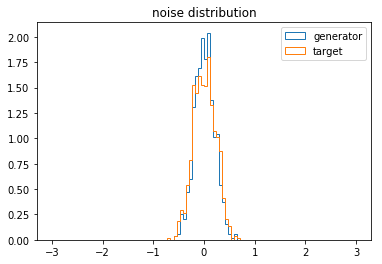

(100, 6)
-0.00493592024 -0.494660199
Time for epoch 1000,
counter 1100:
[-0.0450882539 -0.0437103212 0.147854432 -0.565831244 -0.68213743 -0.273638]
counter 1200:
[-0.35005188 0.479524374 0.129930466 -0.456520408 -0.263191462 -0.0103217959]
counter 1300:
[-0.250038892 0.711597323 0.264672488 -0.606819451 -0.362515599 0.168839455]
counter 1400:
[0.264454365 0.697560191 0.396392077 -0.179815561 -0.65526 -0.390777498]
counter 1500:
[0.205793917 0.710755229 0.480292499 -0.458563447 -0.913419604 -0.405006707]
counter 1600:
[-0.337097883 0.530986 0.978058636 -0.730030894 -0.241463482 -0.397554278]
counter 1700:
[-0.509745538 0.782412231 0.255811155 -0.683509231 -0.244663358 -0.101953581]
counter 1800:
[-0.439721584 0.947944045 -0.075642623 -0.735887825 -0.636539459 0.0843646526]
counter 1900:
[0.0164611451 0.932606161 0.627888858 -0.540169895 -0.200174689 0.118114263]
counter 2000:
[-0.63178885 0.985031784 0.107853383 -0.689903677 -0.489741832 0.213632122]


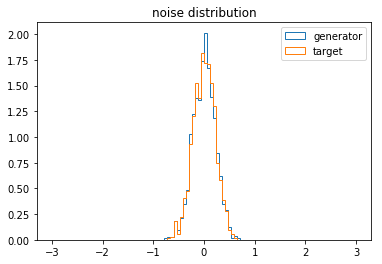

(100, 6)
-0.00493592024 -0.494660199
Time for epoch 2000,
counter 2100:
[-0.248513311 1.10686934 0.381685376 -0.388706863 -0.515807271 -0.0536100194]
counter 2200:
[-0.371452361 0.994396269 0.191346824 -0.524455845 -0.208962753 0.218572542]
counter 2300:
[-0.112771966 0.659901381 0.319673628 -0.212029755 -0.0168675743 -0.0532372]
counter 2400:
[-0.137966797 0.698855162 0.325926632 -0.322608858 -0.0735932589 0.0439237282]
counter 2500:
[-0.143085629 0.954075 0.924851239 -0.314115971 -0.532216847 -0.166335538]
counter 2600:
[-0.178972051 0.530045748 0.185816407 -0.179556638 -0.320316672 -0.181330681]
counter 2700:
[0.0288848132 0.808289051 0.597856522 -0.170420676 0.0518523455 0.0348271392]
counter 2800:
[-0.115757748 0.958490729 0.751454234 -0.3201603 -0.208077684 0.164453819]
counter 2900:
[-0.234498292 0.865600109 0.556072295 -0.350202501 -0.319843739 -0.167913944]
counter 3000:
[-0.0232188366 0.699288249 0.704730868 -0.1963851 -0.0683682784 -0.0309231579]


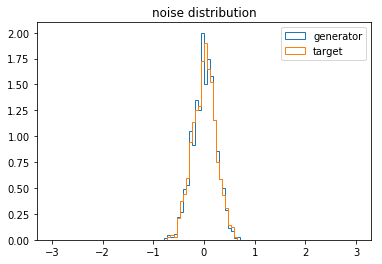

(100, 6)
-0.00493592024 -0.494660199
Time for epoch 3000,
counter 3100:
[-0.181413025 0.863663912 0.772354364 -0.248832107 -0.198207065 -0.045093812]
counter 3200:
[0.226930484 1.17988908 0.772206903 -0.374971777 -0.167442799 0.375496984]
counter 3300:
[-0.0553540625 1.05873525 0.71240443 -0.164811015 -0.324258983 0.227729484]
counter 3400:
[0.0116068944 0.929226756 0.656621575 -0.237422198 0.00530814379 0.0425989442]
counter 3500:
[-0.0363977291 0.944493651 0.626256943 -0.201212168 -0.188008443 0.17011185]
counter 3600:
[-0.032044813 1.09498966 0.721480906 -0.190173522 -0.141020805 -0.0105225742]
counter 3700:
[-0.0599590614 1.09017396 0.72901082 -0.158736184 -0.149642766 0.0787329823]
counter 3800:
[0.0540352389 1.06894481 0.692718804 -0.218370065 -0.0828419626 0.0880290046]
counter 3900:
[-0.0601050183 0.982219458 0.80154407 -0.240083575 -0.216483027 0.00219140947]
counter 4000:
[-0.035607025 0.906114459 0.8488307 -0.0428897142 -0.271930277 0.0470341966]


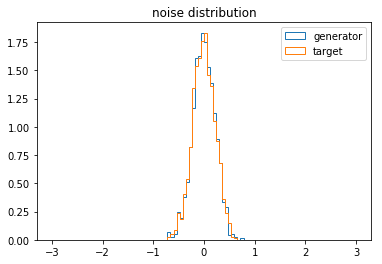

(100, 6)
-0.00493592024 -0.494660199
Time for epoch 4000,
counter 4100:
[-0.163943008 0.832777798 0.802637756 -0.00297873095 -0.22823289 -0.0834520385]
counter 4200:
[-0.0571189523 0.968534589 0.658141 -0.224070311 -0.322441161 -0.106342956]
counter 4300:
[-0.0134045556 1.07737505 0.787171662 -0.35890615 -0.390286893 -0.000785447657]
counter 4400:
[-0.0484952182 1.04749107 0.748180747 -0.322117388 -0.288141668 0.0197065622]
counter 4500:
[-0.0192811303 1.01646757 0.927887678 -0.368558258 -0.294915527 0.0633778423]
counter 4600:
[-0.0179052055 0.893581212 0.706104219 -0.0992062837 -0.321231365 -0.0848868862]
counter 4700:
[-0.0952113569 0.985482454 0.954782844 -0.217583627 -0.268877029 -0.0873832181]
counter 4800:
[-0.0451192521 1.07871914 0.77417779 -0.106511757 -0.23790814 -0.092415072]
counter 4900:
[0.14096269 1.10892701 0.950103462 -0.394113928 -0.313232481 0.137161061]
counter 5000:
[-0.234405398 1.11942315 0.880188107 -0.0223641805 -0.148406297 -0.227519736]


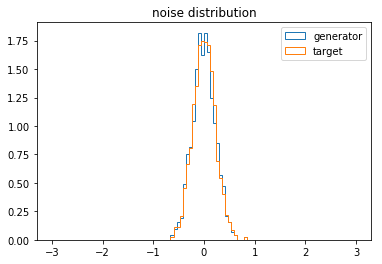

(100, 6)
-0.00493592024 -0.494660199
Time for epoch 5000,
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 37.95916390419006 sec,
tf.Tensor([-1.0483642  -1.3622326  -0.3907679   1.1852125   0.71758825  0.73069876], shape=(6,), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [

In [16]:
%%time
train(epochs, steps_per_epoches , batch_size)
print(generator(x)[1])
generator.summary()
discriminator.summary()



### Setting Generator as not trainable before training AE

In [17]:
generator.trainable = False
tf.print(generator.trainable)

False


## AE
Die Idee sollte sein das Training auf den encoder und decoder einzuschränken. Jedoch soll **end-to-end** trainiert werden, hierfür sollte vllt eine art Funktion eingesetzt werden, welche über die GAN's Layer zurück geht.
Muss ich hierfür die Layer nochmals einzeln definieren?


***Vermutung: Der Ausgang hat die 8fache dimension des Eingangs-> daher nur 1/8 richtig oder 7/8 richtig*** \\
**zu klären: was passiert in meinem AE dass sie dei dimension ver8-facht von (1000,8) zu (8000,n)**
**Kontrollieren was der output von meinem GAN ist**
**Add complexity for higher rubustness**




In [18]:
def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  tf.print(random_hot_one_vector.shape)
  return random_hot_one_vector


EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
GenOut = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


encoder =tf.keras.models.Sequential([EncIn,e1,e2,EncOut,GenIn]) 
decoder =tf.keras.models.Sequential([DecIn,d1,d2,DecOut])

AE = tf.keras.models.Sequential([encoder,generator,decoder])

def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  tf.print(random_hot_one_vector.shape)
  return random_hot_one_vector

data, test_data = generate_data_vector(10000000), generate_data_vector(10000)

AE.compile(optimizer='nadam',loss='categorical_crossentropy',metrics=[B_Ber])
history = AE.fit(data, data, batch_size=500,steps_per_epoch=100, epochs=10)

AE.summary()  

TensorShape([10000000, 512])
TensorShape([10000, 512])
Train on 10000000 samples
Epoch 1/10
   49000/10000000 [..............................] - ETA: 7:32 - loss: 0.0324 - B_Ber: 0.0021Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, None)              3078      
_________________________________________________________________
model (Model)                (None, 6)                 1754      
_________________________________________________________________
sequential_2 (Sequential)    multiple                  266240    
Total params: 271,072
Trainable params: 269,318
Non-trainable params: 1,754
_________________________________________________________________


In [0]:


def analytic_channel(input): 
  #print(input.shape)
  return input + tf.random.normal(tf.shape(input), mean=0.0, stddev=noise_std)

def real_transmision(test_data):
  y = encoder(test_data)
  y = real_channel(y)
  y = decoder(y)
  return y


def test_diff_eval(test_data, results):
  diff = []
  for i in range(tf.shape(test_data)[0]):
    diff.append(tf.math.subtract(test_data[i,:], results[i,:]))
  return diff
    
  
real_AE = real_transmision(test_data)
testTest = tf.dtypes.cast(real_AE + tf.constant(0.2,dtype=tf.float32,shape=tf.shape(real_AE)), tf.int32)

diff_test =  test_diff_eval(test_data, testTest) 





In [20]:
tf.print(sum(diff_test))

[1 2 2 ... 4 7 4]


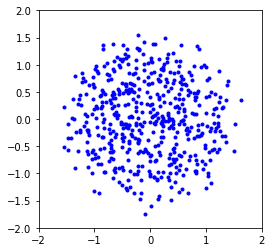

In [21]:
tes_data = np.eye(M, dtype = int)
coding= encoder.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

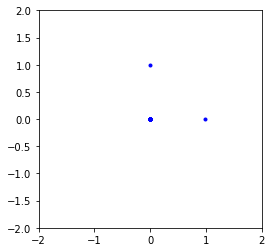

In [22]:
tes_data = np.eye(M, dtype = int)
coding= AE.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

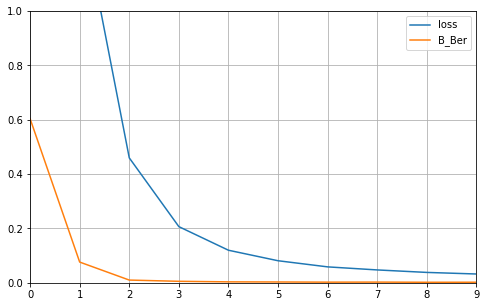

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()